In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np
import random
import math

In [2]:
def stratifySample(features, labels, bs):
    batches = []
    pos = np.where(labels == 1)[0]
    neg = np.where(labels == 0)[0]
    random.shuffle(pos)
    random.shuffle(neg)

    pos_num = len(pos)
    neg_num = len(neg)

    print("positive:{}\tnegative:{}".format(pos_num, neg_num))

    p_r = pos_num / (neg_num + pos_num)
    n_r = 1-p_r


    bs_p = math.ceil(bs * p_r)
    bs_n = bs - bs_p

    batches_p = math.floor(pos_num/bs_p)
    batches_n = math.floor(neg_num/bs_n)


    for i in range(min(batches_p, batches_n)):
        bt_p_features = features[pos[i*bs_p : (i+1)*bs_p]]
        bt_p_labels = labels[pos[i*bs_p : (i+1)*bs_p]]

        bt_n_features = features[neg[i*bs_n : (i+1)*bs_n]]
        bt_n_labels = labels[neg[i*bs_n : (i+1)*bs_n]]

        bt_comb_features = np.concatenate((bt_p_features, bt_n_features), axis = 0)
        bt_comb_labels = np.concatenate((bt_p_labels, bt_n_labels), axis = 0)

        idx = list(range(bs))
        random.shuffle(idx)
        bt_comb_features, bt_comb_labels = bt_comb_features[idx], bt_comb_labels[idx]
        bt_comb_features, bt_comb_labels = map(torch.tensor, (bt_comb_features, bt_comb_labels))
        batches.append((bt_comb_features, bt_comb_labels))
    return batches

In [8]:
blocks = 1
DATA = []
LABEL = []

for i in range(blocks):
    # rootPath = "../../../dataset/diabetic-retinopathy-npy/Messidor1/"
    rootPath = "../../../dataset/diabetic-retinopathy-npz/587/"
    fname = "diabetic-retinopathy-{}.npz".format(i)
    dpath = os.path.join(rootPath, fname)
    print(dpath)

    D = np.load(dpath)
    DATA.extend(D['data'])
    LABEL.extend(D['label'])

DATA = np.asarray(DATA)
LABEL = np.asarray(LABEL)

LABEL[LABEL < 3] = 0
LABEL[LABEL >= 3] = 1

DATA = DATA/255.0
    
print(DATA.shape, LABEL.shape)
print(np.min(DATA), np.max(DATA))

../../../dataset/diabetic-retinopathy-npz/587/diabetic-retinopathy-0.npz
(3514, 587, 587, 3) (3514,)
0.0 1.0


In [9]:
# split into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(DATA, LABEL, test_size=0.2, random_state=42, stratify=LABEL)


data = {}
label = {}
data['train'] = X_train
label['train'] = y_train
data['val'] = X_test
label['val'] = y_test

print(X_train.shape, X_test.shape)

(2811, 587, 587, 3) (703, 587, 587, 3)


In [10]:
# convert to PIL image
from PIL import Image
from matplotlib import cm


PIL_data = {x:[Image.fromarray(np.uint8(data[x][i] * 255)).convert('RGB') for i in range(data[x].shape[0])] for x in ['train', 'val']}
dataset_sizes = {x: len(PIL_data[x]) for x in ['train', 'val']}

print(dataset_sizes)

{'train': 2811, 'val': 703}


In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(299),
#         transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
data_tensor = {x: torch.stack([data_transforms[x](PIL_data[x][i]) for i in range(len(PIL_data[x]))]) for x in ['train', 'val']}
label_tensor = {x: torch.Tensor(label[x]) for x in ['train', 'val']}

In [18]:
# ds = {x: TensorDataset(data_tensor[x], label_tensor[x]) for x in ['train', 'val']}
# dl = {x: DataLoader(ds[x], batch_size=32, shuffle=True, num_workers=8) for x in ['train', 'val']}

bs = 64
dl = {x: stratifySample(data_tensor[x], label_tensor[x], bs) for x in ['train', 'val']}

positive:126	negative:2685
positive:31	negative:672


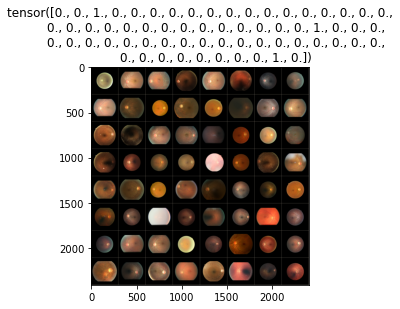

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dl['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=classes)

In [20]:
def my_loss(output, target, criterion):
    
    pos_target = target[target == 1]
    pos_output = output[target == 1]
    
    neg_target = target[target == 0]
    neg_output = output[target == 0]
    
    p_loss = criterion(pos_output, pos_target)/pos_target.shape[0]
    n_loss = criterion(neg_output, neg_target)/neg_target.shape[0]
    
    loss = torch.max(p_loss, n_loss)

    return loss

def train_model(dataloaders, dataset_sizes, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.long()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    if phase == 'train':
                        outputs = outputs.logits
                    _, preds = torch.max(outputs, 1)
                    loss = my_loss(outputs, labels, criterion)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [22]:
model_ft = models.inception_v3(pretrained=False)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-4)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

C:\Users\pengl\anaconda3\lib\site-packages\torchvision\models\inception.py:75: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '


In [23]:
model_ft = train_model(dl, dataset_sizes, model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 8.00 GiB total capacity; 6.02 GiB already allocated; 4.75 MiB free; 6.10 GiB reserved in total by PyTorch)

In [ ]:
PATH = "../../../saved_models/inception_v3.pt"
torch.save(model_ft.state_dict(), PATH)